In [1]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv("dataset_without_anomalies.csv", sep=None, engine="python", encoding="latin1")


In [29]:
df.rename(columns={'ï»¿Invoice': 'Invoice'}, inplace=True)


In [30]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [31]:
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15cm christmas glass ball 20 lights        12   
1  489434    79323P                   pink cherry lights        12   
2  489434    79323W                  white cherry lights        12   
3  489434     22041          record frame 7" single size        48   
4  489434     22064            pink doughnut trinket pot        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-01-12 07:45:00   6.95      13085.0  United Kingdom  
1  2009-01-12 07:45:00   6.75      13085.0  United Kingdom  
2  2009-01-12 07:45:00   6.75      13085.0  United Kingdom  
3  2009-01-12 07:45:00   2.10      13085.0  United Kingdom  
4  2009-01-12 07:45:00   1.65      13085.0  United Kingdom  


In [32]:
print(len(df))

924800


In [33]:
# Supprimer les factures annulées (commençant par 'C')
df = df[~df["Invoice"].astype(str).str.startswith("C")]

In [34]:
print(df.dtypes)

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


In [35]:
# Nettoyer les descriptions
df.loc[:, "Description"] = df["Description"].astype(str).str.strip().str.lower()


In [36]:
# Conversion du champ InvoiceDate en datetime
df.loc[:, "InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")


In [38]:
# Conversion du champ Price en numérique (certaines valeurs sont texte)
# Nettoyage des caractères parasites
df.loc[:, "Price"] = (
    df["Price"].astype(str)
    .str.replace(",", ".", regex=False)
    .str.replace("£", "", regex=False)
    .str.replace("[^0-9.]", "", regex=True)
)

# ✅ Conversion explicite en numérique
df.loc[:, "Price"] = pd.to_numeric(df["Price"], errors="coerce").astype("float64")

In [19]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")


C:\Users\HP\AppData\Local\Temp\ipykernel_5356\4292862720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price"] = pd.to_numeric(df["Price"], errors="coerce")


In [39]:
# Conversion de Quantity en numérique au cas où
df.loc[:, "Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce").astype("float64")

In [40]:
# Supprimer les lignes avec valeurs manquantes ou non valides
df = df.dropna(subset=["Description", "Customer ID", "InvoiceDate", "Price", "Quantity"])

In [41]:
# Supprimer les lignes avec quantités ou prix <= 0
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

In [42]:
print(f"Nombre de lignes après nettoyage : {len(df):,}")

Nombre de lignes après nettoyage : 290,613


In [43]:
# TotalPrice = Quantity * Price
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [45]:
print(df["InvoiceDate"].dtype)


object


In [46]:
# Mois de la facture
df.loc[:, "InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce", dayfirst=True)


In [47]:
print(df["InvoiceDate"].dtype)
print(df["InvoiceDate"].head())

object
0    2009-01-12 07:45:00
1    2009-01-12 07:45:00
2    2009-01-12 07:45:00
3    2009-01-12 07:45:00
4    2009-01-12 07:45:00
Name: InvoiceDate, dtype: object


In [48]:
def categorize_product(desc):
    if "mug" in desc or "cup" in desc:
        return "Cups & Mugs"
    elif "bag" in desc:
        return "Bags"
    elif "candle" in desc:
        return "Candles"
    elif "christmas" in desc or "tree" in desc:
        return "Christmas"
    elif "toy" in desc or "game" in desc:
        return "Toys & Games"
    else:
        return "Other"

df["ProductCategory"] = df["Description"].apply(categorize_product)

In [49]:
print("\nAperçu du dataset nettoyé :")
print(df.head(5))


Aperçu du dataset nettoyé :
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15cm christmas glass ball 20 lights        12   
1  489434    79323P                   pink cherry lights        12   
2  489434    79323W                  white cherry lights        12   
3  489434     22041          record frame 7" single size        48   
4  489434     22064            pink doughnut trinket pot        24   

           InvoiceDate Price  Customer ID         Country TotalPrice  \
0  2009-01-12 07:45:00  6.95      13085.0  United Kingdom       83.4   
1  2009-01-12 07:45:00  6.75      13085.0  United Kingdom       81.0   
2  2009-01-12 07:45:00  6.75      13085.0  United Kingdom       81.0   
3  2009-01-12 07:45:00   2.1      13085.0  United Kingdom      100.8   
4  2009-01-12 07:45:00  1.65      13085.0  United Kingdom       39.6   

  ProductCategory  
0       Christmas  
1           Other  
2           Other  
3           Other  
4           Other

In [50]:
print("\nNombre de produits uniques :", df["Description"].nunique())
print("Nombre de clients uniques :", df["Customer ID"].nunique())
print("Nombre de pays :", df["Country"].nunique())



Nombre de produits uniques : 4932
Nombre de clients uniques : 4238
Nombre de pays : 35


In [51]:
df.to_csv("online_retail_clean2.csv",index=False, encoding="utf-8")

2. analyse exploration descriptive par produit

la partie EDA sur les produits, c’est-à-dire comprendre le comportement des produits avant de faire ta segmentation produit (clustering).

Identifier :

les produits les plus vendus, les plus rentables, ou les moins performants,

les relations entre prix, quantité et revenu,

et construire la base de features pour le clustering.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style graphique
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Chargement du dataset propre
df = pd.read_csv("online_retail_clean2.csv")

In [53]:
 #2. Vue d’ensemble du dataset
# =====================================================
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290613 entries, 0 to 290612
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Invoice          290613 non-null  int64  
 1   StockCode        290613 non-null  object 
 2   Description      290613 non-null  object 
 3   Quantity         290613 non-null  int64  
 4   InvoiceDate      290613 non-null  object 
 5   Price            290613 non-null  float64
 6   Customer ID      290613 non-null  float64
 7   Country          290613 non-null  object 
 8   TotalPrice       290613 non-null  float64
 9   ProductCategory  290613 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 22.2+ MB
None


In [54]:
print(df.head())

   Invoice StockCode                          Description  Quantity  \
0   489434     85048  15cm christmas glass ball 20 lights        12   
1   489434    79323P                   pink cherry lights        12   
2   489434    79323W                  white cherry lights        12   
3   489434     22041          record frame 7" single size        48   
4   489434     22064            pink doughnut trinket pot        24   

           InvoiceDate  Price  Customer ID         Country  TotalPrice  \
0  2009-01-12 07:45:00   6.95      13085.0  United Kingdom        83.4   
1  2009-01-12 07:45:00   6.75      13085.0  United Kingdom        81.0   
2  2009-01-12 07:45:00   6.75      13085.0  United Kingdom        81.0   
3  2009-01-12 07:45:00   2.10      13085.0  United Kingdom       100.8   
4  2009-01-12 07:45:00   1.65      13085.0  United Kingdom        39.6   

  ProductCategory  
0       Christmas  
1           Other  
2           Other  
3           Other  
4           Other  


In [55]:
print("\nNombre de produits uniques :", df["Description"].nunique())
print("Nombre de transactions :", df["Invoice"].nunique())
print("Nombre total de lignes :", len(df))


Nombre de produits uniques : 4932
Nombre de transactions : 14722
Nombre total de lignes : 290613


In [56]:
# Vérifier les statistiques globales
print("\nStatistiques descriptives :")
print(df[["Quantity", "Price", "TotalPrice"]].describe())


Statistiques descriptives :
            Quantity          Price     TotalPrice
count  290613.000000  290613.000000  290613.000000
mean       12.061264       2.978326      20.882106
std       159.437456       3.539163     320.732306
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       4.350000
50%         4.000000       1.950000      10.500000
75%        12.000000       3.750000      17.850000
max     80995.000000     195.000000  168469.600000


In [57]:
product_stats = (
    df.groupby("Description")
    .agg({
        "Quantity": "sum",       # volume total vendu
        "TotalPrice": "sum",     # revenu total
        "Price": "mean",         # prix moyen
        "Invoice": "nunique"     # nombre de factures contenant ce produit
    })
    .rename(columns={"Invoice": "NumInvoices"})
    .reset_index()
)

In [58]:
print("\nAperçu des statistiques par produit :")
print(product_stats.head())


Aperçu des statistiques par produit :
                         Description  Quantity  TotalPrice     Price  \
0             10 colour spaceboy pen      5579     4634.51  0.854099   
1     11 pc ceramic tea set polkadot         3       14.85  4.950000   
2  12 ass zinc christmas decorations       241      506.10  2.100000   
3         12 coloured party balloons      2056     1276.40  0.645455   
4          12 daisy pegs in wood box       393      648.45  1.650000   

   NumInvoices  
0          202  
1            1  
2           24  
3          100  
4           72  


In [59]:
# 4. Top produits vendus
# =====================================================

# Top 10 par volume
top_quantity = product_stats.sort_values("Quantity", ascending=False).head(10)
# Top 10 par revenu
top_revenue = product_stats.sort_values("TotalPrice", ascending=False).head(10)

C:\Users\HP\AppData\Local\Temp\ipykernel_5356\572328276.py:7: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\anaconda3\envs\data_mining_project\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


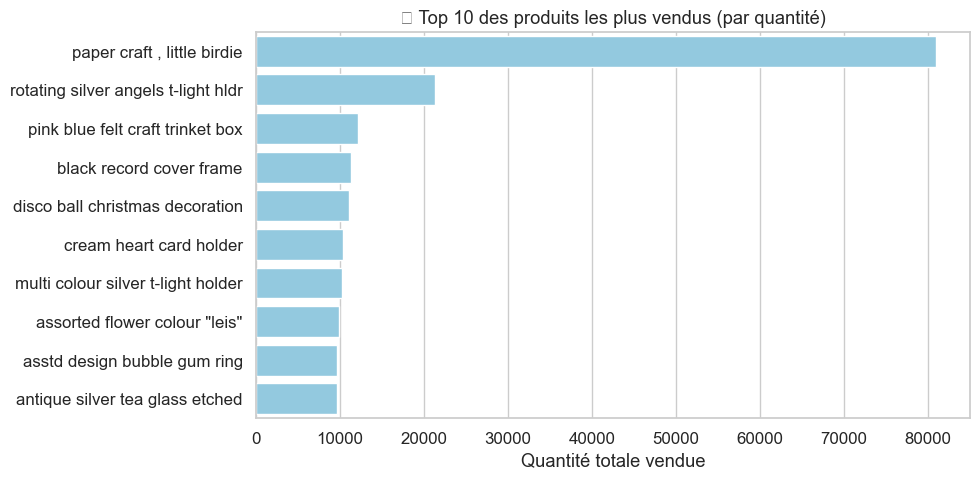

In [60]:
# --- Graphiques ---
plt.figure(figsize=(10, 5))
sns.barplot(data=top_quantity, y="Description", x="Quantity", color="skyblue")
plt.title("🏆 Top 10 des produits les plus vendus (par quantité)")
plt.xlabel("Quantité totale vendue")
plt.ylabel("")
plt.tight_layout()
plt.show()

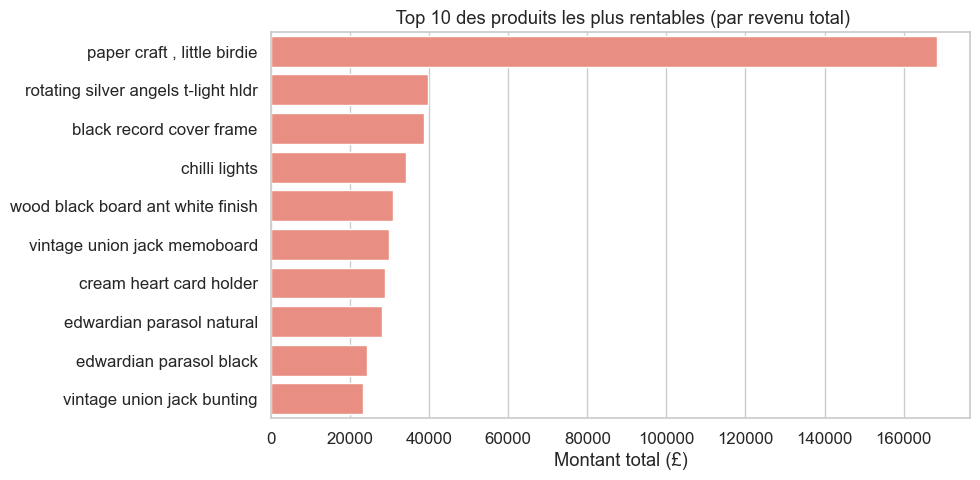

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(data=top_revenue, y="Description", x="TotalPrice", color="salmon")
plt.title(" Top 10 des produits les plus rentables (par revenu total)")
plt.xlabel("Montant total (£)")
plt.ylabel("")
plt.tight_layout()
plt.show()

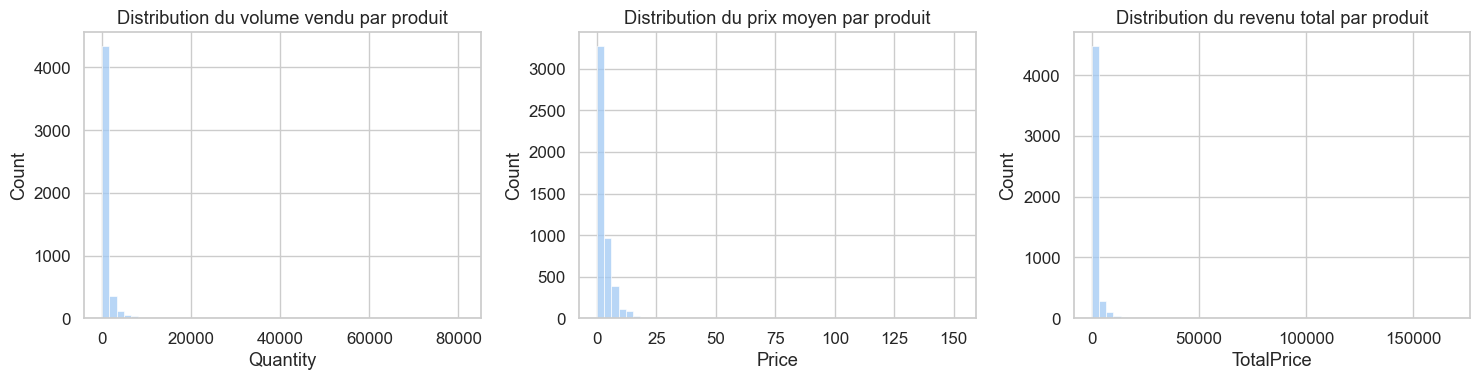

In [62]:
# 5. Distribution des variables
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(product_stats["Quantity"], bins=50, ax=axes[0])
axes[0].set_title("Distribution du volume vendu par produit")

sns.histplot(product_stats["Price"], bins=50, ax=axes[1])
axes[1].set_title("Distribution du prix moyen par produit")

sns.histplot(product_stats["TotalPrice"], bins=50, ax=axes[2])
axes[2].set_title("Distribution du revenu total par produit")

plt.tight_layout()
plt.show()

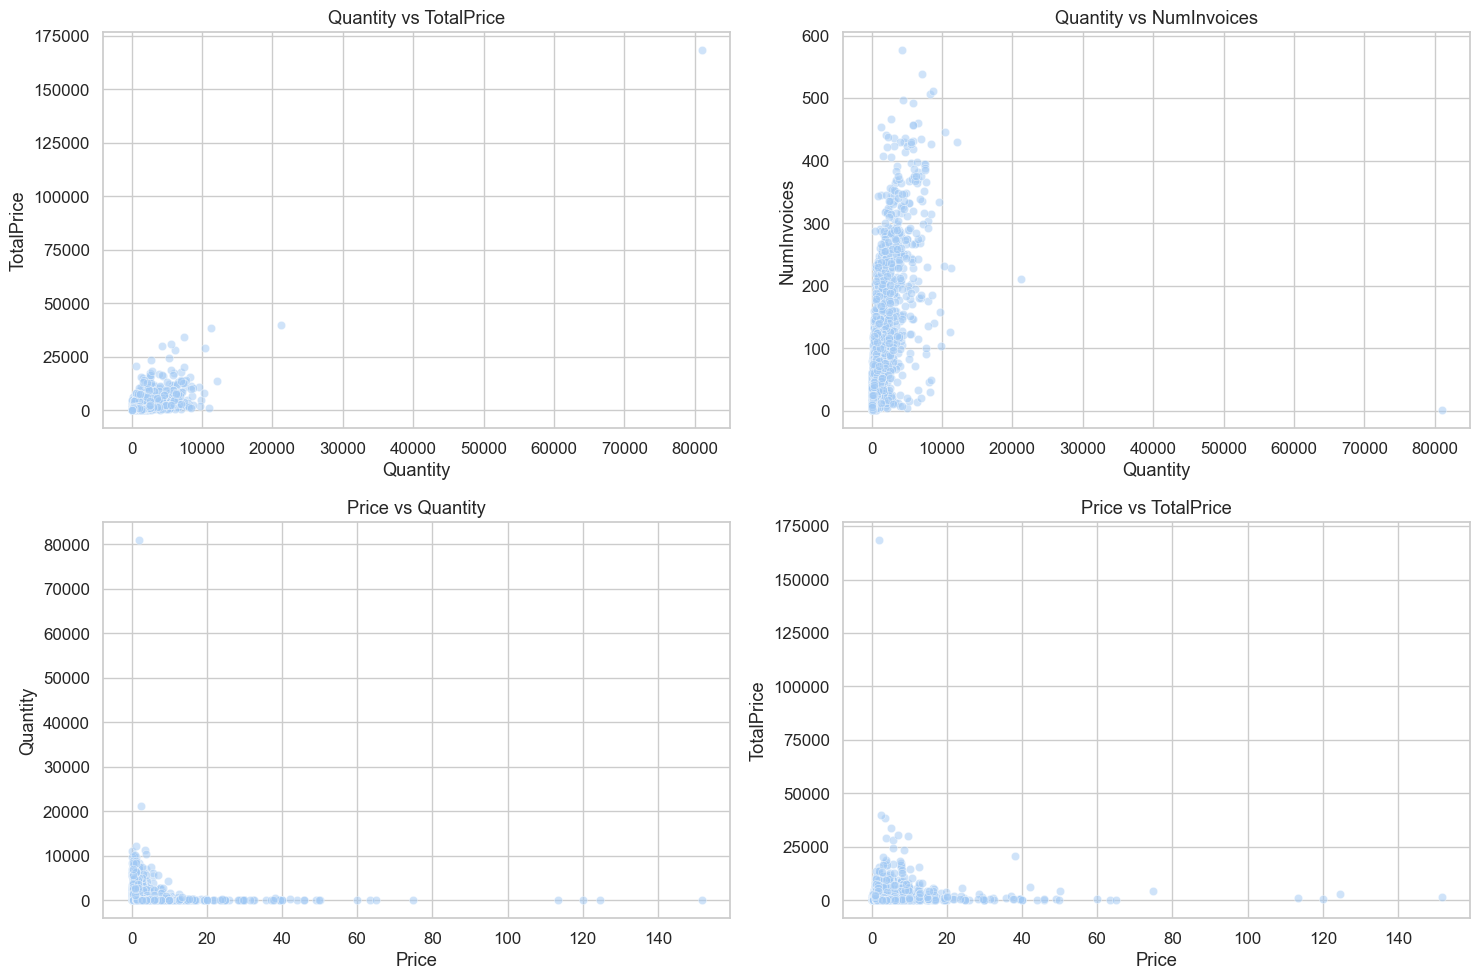

In [63]:
plt.figure(figsize=(15, 10))

# Quantity vs TotalPrice
plt.subplot(2, 2, 1)
sns.scatterplot(data=product_stats, x="Quantity", y="TotalPrice", alpha=0.5)
plt.title("Quantity vs TotalPrice")

# Quantity vs NumInvoices
plt.subplot(2, 2, 2)
sns.scatterplot(data=product_stats, x="Quantity", y="NumInvoices", alpha=0.5)
plt.title("Quantity vs NumInvoices")

# Price vs Quantity
plt.subplot(2, 2, 3)
sns.scatterplot(data=product_stats, x="Price", y="Quantity", alpha=0.5)
plt.title("Price vs Quantity")

# Price vs TotalPrice
plt.subplot(2, 2, 4)
sns.scatterplot(data=product_stats, x="Price", y="TotalPrice", alpha=0.5)
plt.title("Price vs TotalPrice")

plt.tight_layout()
plt.show()



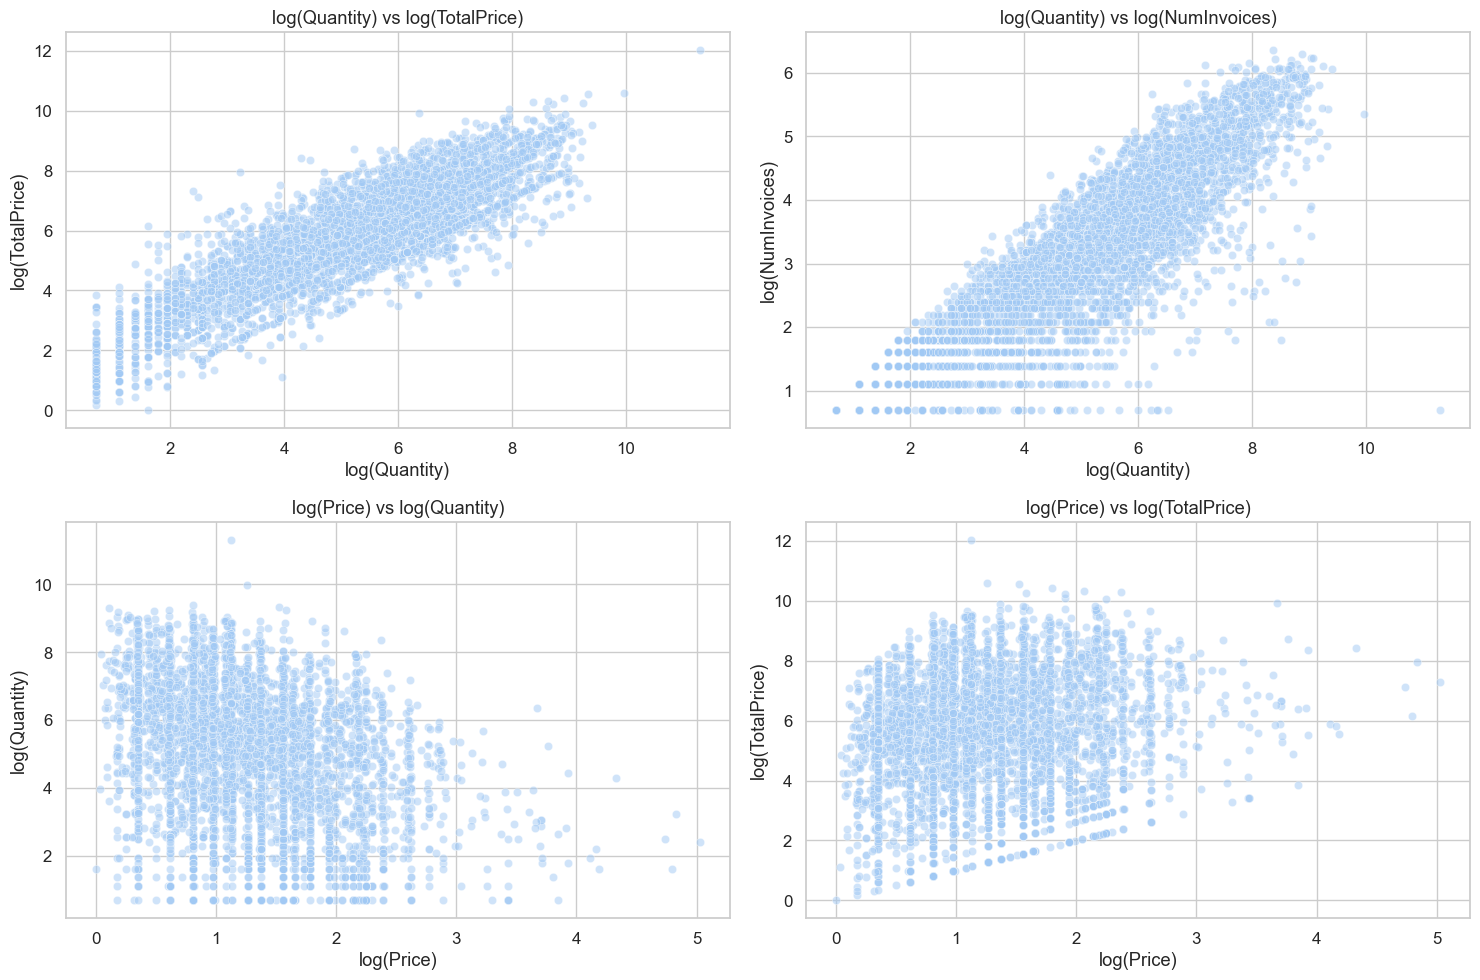

In [64]:
# Création d'une version log-transformée du dataset
log_data = np.log1p(product_stats[["Quantity", "Price", "TotalPrice", "NumInvoices"]])

# Création des scatter plots log-log
plt.figure(figsize=(15, 10))

# 1️⃣ Quantity vs TotalPrice
plt.subplot(2, 2, 1)
sns.scatterplot(data=log_data, x="Quantity", y="TotalPrice", alpha=0.5)
plt.title("log(Quantity) vs log(TotalPrice)")
plt.xlabel("log(Quantity)")
plt.ylabel("log(TotalPrice)")

# 2️⃣ Quantity vs NumInvoices
plt.subplot(2, 2, 2)
sns.scatterplot(data=log_data, x="Quantity", y="NumInvoices", alpha=0.5)
plt.title("log(Quantity) vs log(NumInvoices)")
plt.xlabel("log(Quantity)")
plt.ylabel("log(NumInvoices)")

# 3️⃣ Price vs Quantity
plt.subplot(2, 2, 3)
sns.scatterplot(data=log_data, x="Price", y="Quantity", alpha=0.5)
plt.title("log(Price) vs log(Quantity)")
plt.xlabel("log(Price)")
plt.ylabel("log(Quantity)")

# 4️⃣ Price vs TotalPrice
plt.subplot(2, 2, 4)
sns.scatterplot(data=log_data, x="Price", y="TotalPrice", alpha=0.5)
plt.title("log(Price) vs log(TotalPrice)")
plt.xlabel("log(Price)")
plt.ylabel("log(TotalPrice)")

plt.tight_layout()
plt.show()



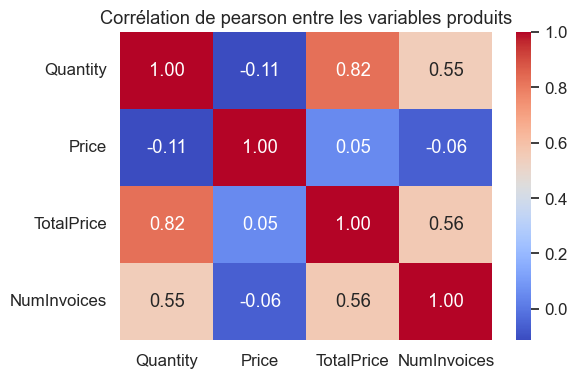

In [65]:
# 6. Corrélations entre variables produits
# =====================================================
corr = product_stats[["Quantity", "Price", "TotalPrice", "NumInvoices"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation de pearson entre les variables produits")
plt.show()

c:\Users\HP\anaconda3\envs\data_mining_project\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


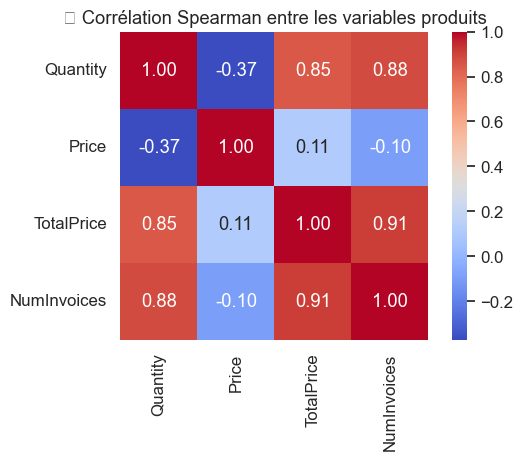

In [66]:
# Calcul de la matrice de corrélation Spearman
corr_spearman = product_stats[["Quantity", "Price", "TotalPrice", "NumInvoices"]].corr(method="spearman")

# Affichage de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_spearman, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("🔥 Corrélation Spearman entre les variables produits")
plt.show()


In [67]:
from scipy.stats import spearmanr, pearsonr

# Spearman (relation monotone, non linéaire)
corr_s, p_s = spearmanr(product_stats["Price"], product_stats["Quantity"])
print(f"Spearman correlation: {corr_s:.3f}, p-value: {p_s:.5f}")




Spearman correlation: -0.371, p-value: 0.00000


L’analyse de la corrélation de Spearman entre le prix moyen (Price) et la quantité totale vendue (Quantity) donne un coefficient de -0.373 avec une p-value ≈ 0.00000.

Cette p-value extrêmement faible (< 0.05) indique que la probabilité que cette corrélation apparaisse par hasard est quasi nulle.
Autrement dit, la relation observée est hautement significative sur le plan statistique.

On peut conclure avec un fort degré de confiance qu’il existe une relation monotone négative réelle entre le prix et le volume vendu :
à mesure que le prix augmente, la quantité vendue diminue.

Clustering

In [68]:
# On garde les variables quantitatives
features = product_stats[["Quantity", "Price", "TotalPrice", "NumInvoices"]].copy()

# Transformation logarithmique (pour réduire l’effet des valeurs extrêmes)
features_log = np.log1p(features)

# Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_log)

print("\n✅ Données prêtes pour le clustering (K-Means / GMM / DBSCAN)")


✅ Données prêtes pour le clustering (K-Means / GMM / DBSCAN)


In [69]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,ProductCategory
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,83.4,Christmas
1,489434,79323P,pink cherry lights,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,81.0,Other
2,489434,79323W,white cherry lights,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,81.0,Other
3,489434,22041,"record frame 7"" single size",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom,100.8,Other
4,489434,22064,pink doughnut trinket pot,24,2009-01-12 07:45:00,1.65,13085.0,United Kingdom,39.6,Other


In [70]:
print(X_scaled.shape)


(4932, 4)


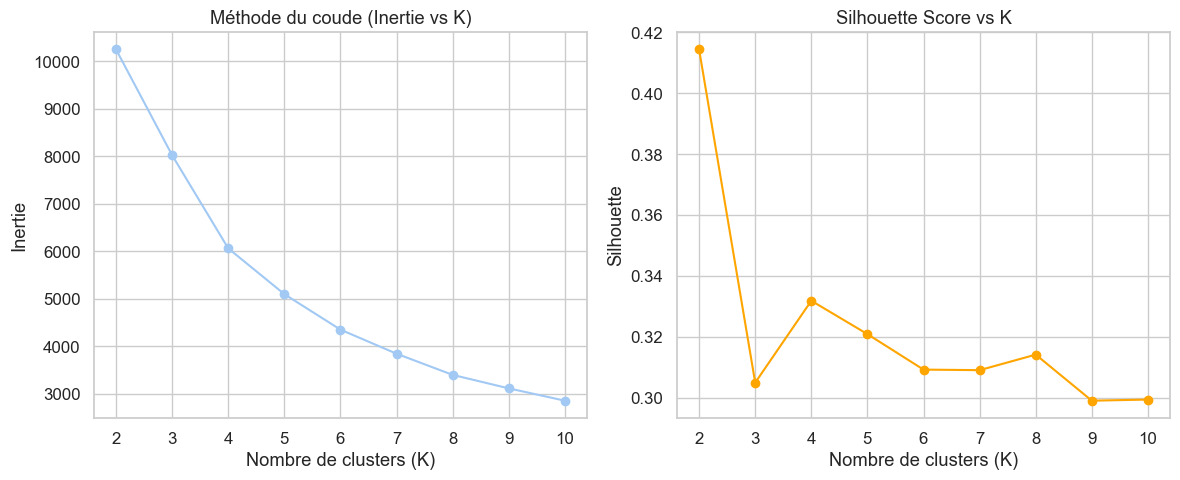

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation
fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

# Méthode du coude
ax1[0].plot(K_range, inertia, marker='o')
ax1[0].set_title("Méthode du coude (Inertie vs K)")
ax1[0].set_xlabel("Nombre de clusters (K)")
ax1[0].set_ylabel("Inertie")

# Score de silhouette
ax1[1].plot(K_range, silhouette, marker='o', color='orange')
ax1[1].set_title("Silhouette Score vs K")
ax1[1].set_xlabel("Nombre de clusters (K)")
ax1[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()


Analyse silhouette score :

Pour K=2, le score était le plus haut (meilleure séparation globale).

Pour K=4, le score était un peu plus faible mais restait bon donc plus de richesse dans les segments sans trop perdre en qualité.

C’est ce qui m’a permis de choisir K=4 : un bon compromis entre qualité et interprétation business.

Bien que la méthode du coude soit souvent utilisée pour estimer le nombre de clusters, elle reste une approche heuristique et subjective, sans fondement théorique solide.
Dans ce projet, le choix du nombre optimal de clusters s’appuie plutôt sur des critères plus rigoureux — notamment le coefficient de silhouette pour K-Means et les critères AIC/BIC pour GMM — afin d’obtenir une segmentation statistiquement cohérente et interprétable sur le plan métier.

In [73]:
product_stats

,Description,Quantity,TotalPrice,Price,NumInvoices
0,10 colour spaceboy pen,5579,4634.51,0.854099,202
1,11 pc ceramic tea set polkadot,3,14.85,4.950000,1
2,12 ass zinc christmas decorations,241,506.10,2.100000,24
3,12 coloured party balloons,2056,1276.40,0.645455,100
4,12 daisy pegs in wood box,393,648.45,1.650000,72
...,...,...,...,...,...
4927,zinc t-light holder stars small,2516,1978.20,0.829266,109
4928,zinc top 2 door wooden shelf,166,925.70,10.061111,26
4929,zinc willie winkie candle stick,2653,2219.95,0.851931,188
4930,zinc wire kitchen organiser,20,104.80,6.100000,9


*  K-Means final avec k=4 :

In [ ]:
from sklearn.cluster import KMeans

best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
product_stats["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)

Silhouette Score moyen : 0.332


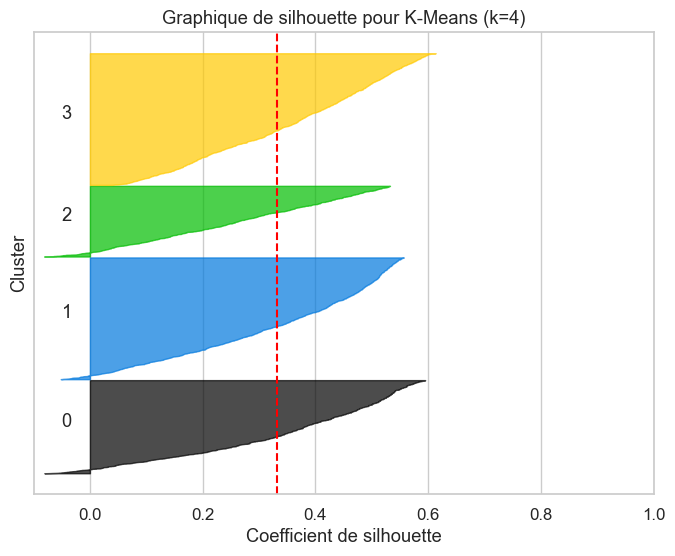

In [75]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# On réutilise les labels du modèle K-Means
labels = product_stats["Cluster_KMeans"]
n_clusters = len(np.unique(labels))

# Calcul des scores individuels
silhouette_vals = silhouette_samples(X_scaled, labels)

# Score moyen global
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score moyen : {silhouette_avg:.3f}")

# Visualisation
fig, ax1 = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(n_clusters):
    # Récupérer les scores du cluster i
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_silhouette_vals,
        facecolor=color, edgecolor=color, alpha=0.7
    )

    # Étiquette du cluster
    ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10  # espace entre les clusters

# Ligne verticale du score moyen global
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_title("Graphique de silhouette pour K-Means (k=4)")
ax1.set_xlabel("Coefficient de silhouette")
ax1.set_ylabel("Cluster")
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
plt.show()


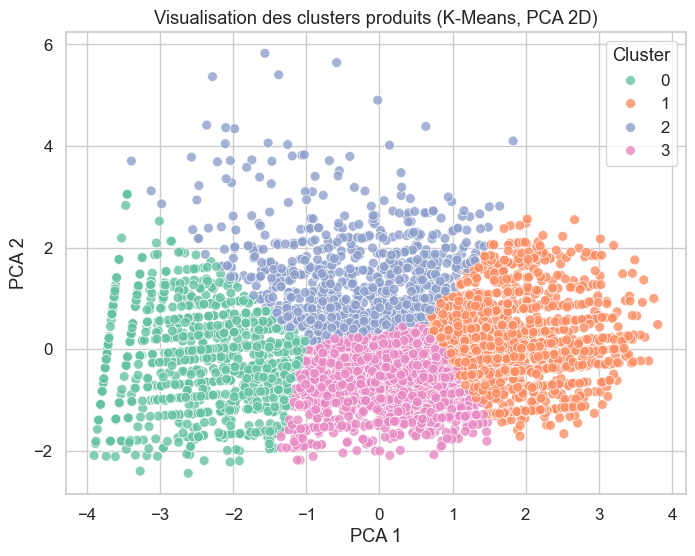

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Réduction de dimension à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Ajout des coordonnées PCA dans le DataFrame
product_stats["PCA1"] = X_pca[:, 0]
product_stats["PCA2"] = X_pca[:, 1]

# Visualisation des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=product_stats,
    x="PCA1", y="PCA2",
    hue="Cluster_KMeans",
    palette="Set2",
    s=50, alpha=0.8
)
plt.title("Visualisation des clusters produits (K-Means, PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()


In [78]:
cluster_summary = (
    product_stats.groupby("Cluster_KMeans")[["Quantity", "Price", "TotalPrice", "NumInvoices"]]
    .mean()
    .round(2)
    .sort_index()
)

print("📘 Profil moyen par cluster :")
display(cluster_summary)


📘 Profil moyen par cluster :


,Quantity,Price,TotalPrice,NumInvoices
Cluster_KMeans,,,,
0,19.38,3.25,36.40,3.52
1,1893.41,2.61,3384.71,141.57
2,113.06,9.29,759.34,25.33
3,427.18,1.34,336.20,26.67


* Cluster 0 : Produits dormants / peu demandés — Faible volume, faible revenu, prix modéré. Produits achetés occasionnellement.

* Cluster 1:Produits stars / best-sellers — Forte quantité, revenus élevés, très présents dans les factures. Produits populaires et générateurs de volume.

* Cluster 2:  Produits premium — Prix élevé, ventes limitées mais revenu unitaire important. Produits de niche ou haut de gamme.

* Cluster3:  Produits de rotation moyenne — Prix très bas, vendus régulièrement. Produits de base ou consommables.




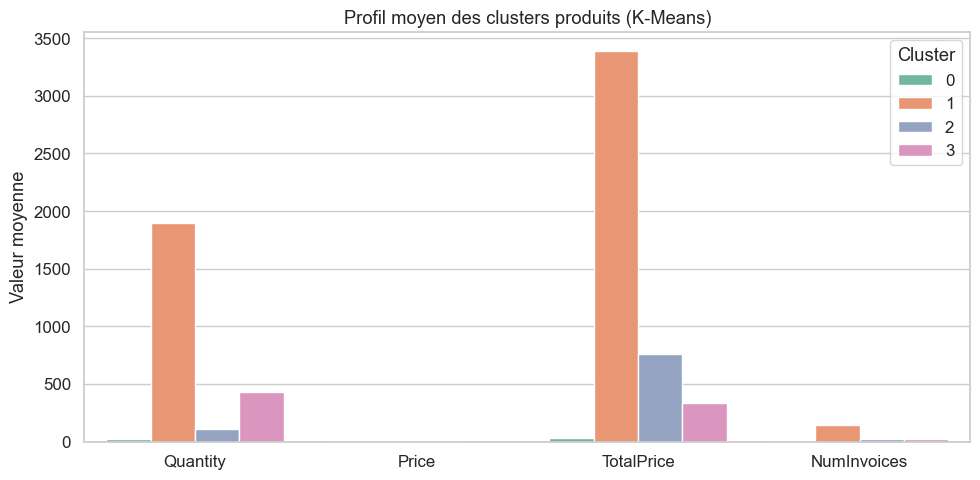

In [79]:
# Moyennes par cluster
cluster_summary = (
    product_stats.groupby("Cluster_KMeans")[["Quantity", "Price", "TotalPrice", "NumInvoices"]]
    .mean()
    .round(2)
    .reset_index()
)

# Transformation pour visualiser facilement
cluster_melted = cluster_summary.melt(id_vars="Cluster_KMeans", var_name="Variable", value_name="Valeur")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=cluster_melted,
    x="Variable", y="Valeur",
    hue="Cluster_KMeans", palette="Set2"
)
plt.title("Profil moyen des clusters produits (K-Means)")
plt.xlabel("")
plt.ylabel("Valeur moyenne")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


GMM

Covariance: full → Silhouette Score = 0.041
Covariance: tied → Silhouette Score = 0.269
Covariance: diag → Silhouette Score = 0.245
Covariance: spherical → Silhouette Score = 0.324


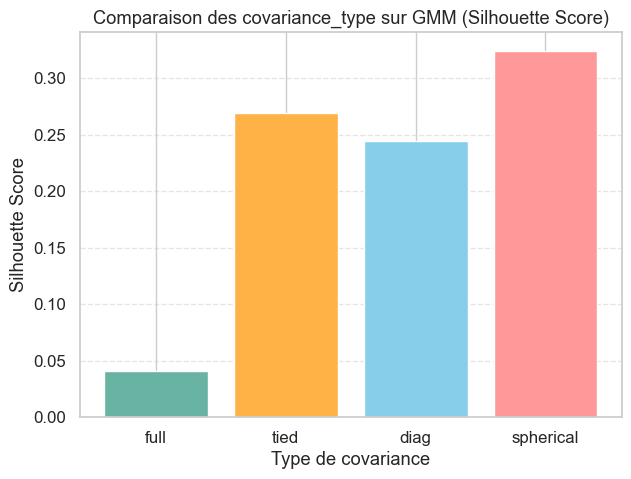

In [80]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Liste des types de covariance à tester
cov_types = ['full', 'tied', 'diag', 'spherical']
silhouette_scores = []

for cov in cov_types:
    gmm = GaussianMixture(
        n_components=4,           # même nombre de clusters que K-Means
        covariance_type=cov,
        random_state=42,
        n_init=10
    )
    
    labels = gmm.fit_predict(X_scaled)
    
    # Certains modèles peuvent produire 1 seul cluster => on vérifie avant le calcul
    if len(set(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')  # impossible à évaluer
    
    silhouette_scores.append(score)
    print(f"Covariance: {cov} → Silhouette Score = {score:.3f}")

# --- Visualisation ---
plt.figure(figsize=(7,5))
plt.bar(cov_types, silhouette_scores, color=['#69b3a2', '#ffb347', '#87CEEB', '#FF9999'])
plt.title("Comparaison des covariance_type sur GMM (Silhouette Score)")
plt.xlabel("Type de covariance")
plt.ylabel("Silhouette Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Covariance: full → BIC = 17905.25, AIC = 17521.54
Covariance: tied → BIC = 25137.61, AIC = 24949.01
Covariance: diag → BIC = 40947.25, AIC = 40719.62
Covariance: spherical → BIC = 44345.12, AIC = 44195.54


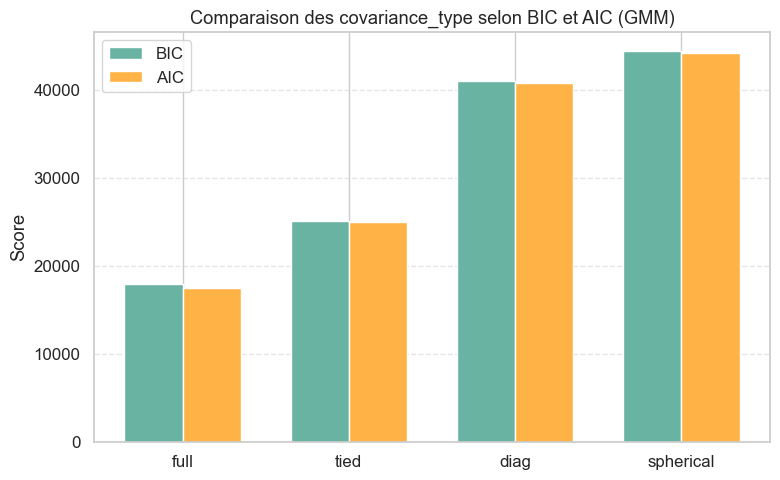

In [81]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

cov_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = []
aic_scores = []

for cov in cov_types:
    gmm = GaussianMixture(
        n_components=4,          # même nombre de clusters
        covariance_type=cov,
        random_state=42,
        n_init=10
    )
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    aic = gmm.aic(X_scaled)
    
    bic_scores.append(bic)
    aic_scores.append(aic)
    
    print(f"Covariance: {cov} → BIC = {bic:.2f}, AIC = {aic:.2f}")

# --- Visualisation ---
x = np.arange(len(cov_types))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, bic_scores, width, label="BIC", color="#69b3a2")
plt.bar(x + width/2, aic_scores, width, label="AIC", color="#ffb347")
plt.xticks(x, cov_types)
plt.ylabel("Score")
plt.title("Comparaison des covariance_type selon BIC et AIC (GMM)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


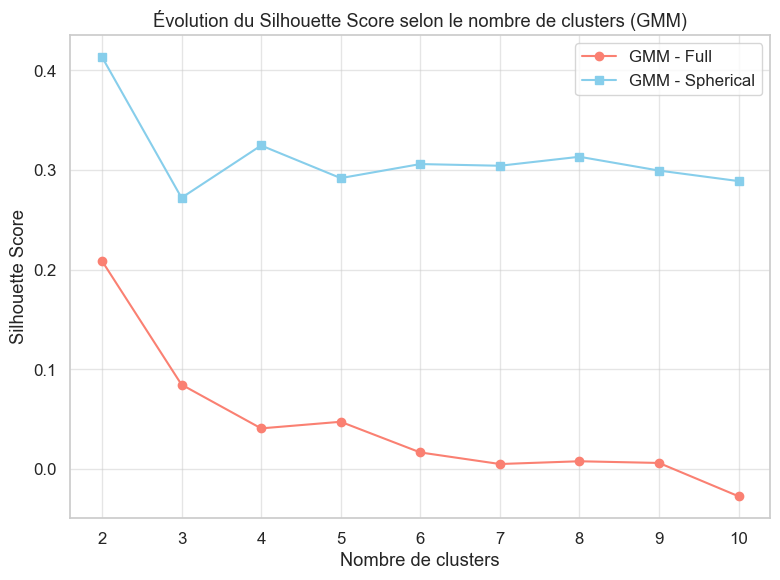

In [82]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1️⃣ Définition du range de clusters à tester ---
range_n = range(2, 11)  # entre 2 et 10 clusters

sil_scores_full = []
sil_scores_spherical = []

# --- 2️⃣ Calcul du Silhouette Score pour chaque nombre de clusters ---
for n in range_n:
    # GMM Full
    gmm_full = GaussianMixture(
        n_components=n,
        covariance_type='full',
        random_state=42,
        n_init=10
    )
    labels_full = gmm_full.fit_predict(X_scaled)
    if len(set(labels_full)) > 1:  # éviter erreur silhouette (1 seul cluster)
        sil_scores_full.append(silhouette_score(X_scaled, labels_full))
    else:
        sil_scores_full.append(np.nan)

    # GMM Spherical
    gmm_spherical = GaussianMixture(
        n_components=n,
        covariance_type='spherical',
        random_state=42,
        n_init=10
    )
    labels_spherical = gmm_spherical.fit_predict(X_scaled)
    if len(set(labels_spherical)) > 1:
        sil_scores_spherical.append(silhouette_score(X_scaled, labels_spherical))
    else:
        sil_scores_spherical.append(np.nan)

# --- 3️⃣ Visualisation ---
plt.figure(figsize=(8,6))
plt.plot(range_n, sil_scores_full, marker='o', label="GMM - Full", color="salmon")
plt.plot(range_n, sil_scores_spherical, marker='s', label="GMM - Spherical", color="skyblue")
plt.title("Évolution du Silhouette Score selon le nombre de clusters (GMM)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


Silhouette Score (GMM full) : 0.041
Silhouette Score (GMM spherical) : 0.324


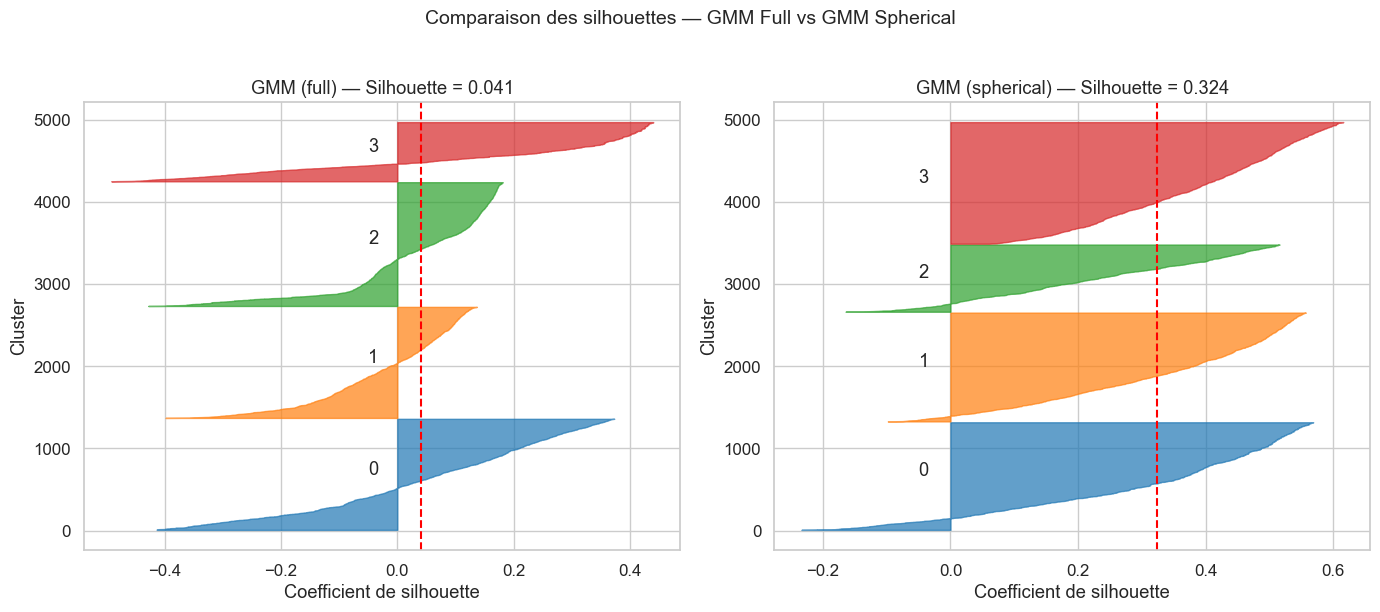

In [83]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Entraînement des deux modèles ---
gmm_full = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=42,
    n_init=10
)
labels_full = gmm_full.fit_predict(X_scaled)

gmm_spherical = GaussianMixture(
    n_components=4,
    covariance_type='spherical',
    random_state=42,
    n_init=10
)
labels_spherical = gmm_spherical.fit_predict(X_scaled)

# --- 2️⃣ Calcul des silhouettes ---
sil_full = silhouette_score(X_scaled, labels_full)
sil_spherical = silhouette_score(X_scaled, labels_spherical)
samples_full = silhouette_samples(X_scaled, labels_full)
samples_spherical = silhouette_samples(X_scaled, labels_spherical)

print(f"Silhouette Score (GMM full) : {sil_full:.3f}")
print(f"Silhouette Score (GMM spherical) : {sil_spherical:.3f}")

# --- 3️⃣ Visualisation comparative ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
titles = [f"GMM (full) — Silhouette = {sil_full:.3f}",
          f"GMM (spherical) — Silhouette = {sil_spherical:.3f}"]
labels_list = [labels_full, labels_spherical]
samples_list = [samples_full, samples_spherical]

for ax, title, labels, sample_values in zip(axes, titles, labels_list, samples_list):
    y_lower = 10
    n_clusters = len(np.unique(labels))
    colors = sns.color_palette("tab10", n_clusters)

    for i, color in enumerate(colors):
        cluster_vals = sample_values[labels == i]
        cluster_vals.sort()
        size_cluster_i = cluster_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_vals,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # espace entre clusters

    ax.axvline(x=sil_full if "full" in title else sil_spherical, color="red", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Coefficient de silhouette")
    ax.set_ylabel("Cluster")

plt.suptitle("Comparaison des silhouettes — GMM Full vs GMM Spherical", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


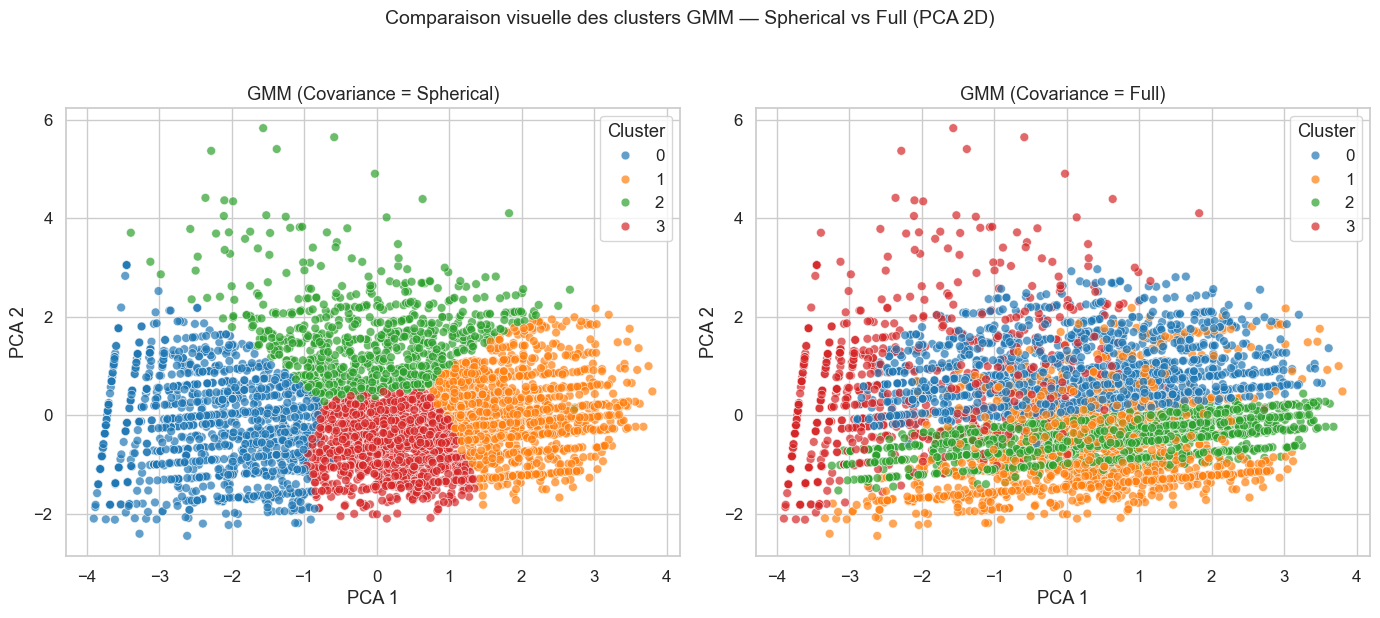

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# --- Réduction dimensionnelle (PCA) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# ---  GMM spherical ---
gmm_spherical = GaussianMixture(
    n_components=4,
    covariance_type='spherical',
    random_state=42,
    n_init=10
)
labels_spherical = gmm_spherical.fit_predict(X_scaled)

# ---  GMM full ---
gmm_full = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=42,
    n_init=10
)
labels_full = gmm_full.fit_predict(X_scaled)

# ---  Visualisation comparative ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- GMM spherical ---
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=labels_spherical,
    palette="tab10", alpha=0.7, s=40, ax=axes[0]
)
axes[0].set_title("GMM (Covariance = Spherical)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")
axes[0].legend(title="Cluster")

# --- GMM full ---
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=labels_full,
    palette="tab10", alpha=0.7, s=40, ax=axes[1]
)
axes[1].set_title("GMM (Covariance = Full)")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")
axes[1].legend(title="Cluster")

plt.suptitle("Comparaison visuelle des clusters GMM — Spherical vs Full (PCA 2D)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()


In [85]:
# ⚙️ Assure-toi que tu as déjà les labels du GMM spherical :
labels_gmm_spherical = gmm_spherical.fit_predict(X_scaled)

# Ajouter les labels au DataFrame produit
product_stats["Cluster_GMM_Spherical"] = labels_gmm_spherical

# Calcul des moyennes par cluster
gmm_spherical_summary = (
    product_stats.groupby("Cluster_GMM_Spherical")[["Quantity", "Price", "TotalPrice", "NumInvoices"]]
    .mean()
    .round(2)
)

display(gmm_spherical_summary)


,Quantity,Price,TotalPrice,NumInvoices
Cluster_GMM_Spherical,,,,
0,29.03,3.20,47.69,4.21
1,1969.02,2.28,3283.39,145.13
2,262.28,9.64,1364.20,36.96
3,436.21,1.41,366.90,28.64


Le modèle GMM (spherical) permet d’identifier quatre profils distincts de produits :

Cluster 1 – Produits Stars : très populaires, génèrent le plus gros chiffre d’affaires.

Cluster 2 – Produits Premium : articles haut de gamme vendus en quantités plus faibles.

Cluster 3 – Produits à rotation moyenne : produits abordables à volume stable.

Cluster 0 – Produits Dormants : faibles ventes et peu de commandes.

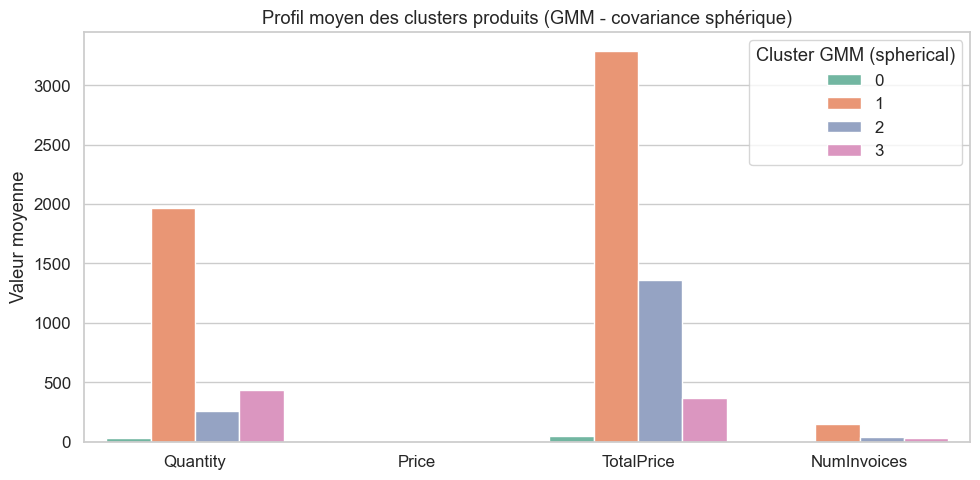

In [86]:
# =====================================================
# Profil moyen des clusters produits (GMM - covariance sphérique)
# =====================================================

# Calcul des moyennes par cluster GMM sphérique
gmm_spherical_summary = (
    product_stats.groupby("Cluster_GMM_Spherical")[["Quantity", "Price", "TotalPrice", "NumInvoices"]]
    .mean()
    .round(2)
    .reset_index()
)

# Transformation en format long (pour seaborn)
gmm_spherical_melted = gmm_spherical_summary.melt(
    id_vars="Cluster_GMM_Spherical", 
    var_name="Variable", 
    value_name="Valeur"
)

# Visualisation
plt.figure(figsize=(10, 5))
sns.barplot(
    data=gmm_spherical_melted,
    x="Variable", y="Valeur",
    hue="Cluster_GMM_Spherical", palette="Set2"
)
plt.title("Profil moyen des clusters produits (GMM - covariance sphérique)")
plt.xlabel("")
plt.ylabel("Valeur moyenne")
plt.legend(title="Cluster GMM (spherical)")
plt.tight_layout()
plt.show()


Pour évaluer un modèle de clustering, en plus du Silhouette Score, on utilise souvent Calinski–Harabasz et Davies–Bouldin (surtout quand on compare des méthodes comme GMM et K-Means).

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# =====================================================
#  Évaluation K-Means vs GMM (covariance sphérique)
# =====================================================

# Évaluation K-Means
sil_kmeans = silhouette_score(X_scaled, product_stats["Cluster_KMeans"])
ch_kmeans = calinski_harabasz_score(X_scaled, product_stats["Cluster_KMeans"])
db_kmeans = davies_bouldin_score(X_scaled, product_stats["Cluster_KMeans"])

# Évaluation GMM (covariance sphérique)
sil_gmm_sph = silhouette_score(X_scaled, product_stats["Cluster_GMM_Spherical"])
ch_gmm_sph = calinski_harabasz_score(X_scaled, product_stats["Cluster_GMM_Spherical"])
db_gmm_sph = davies_bouldin_score(X_scaled, product_stats["Cluster_GMM_Spherical"])

# Résumé comparatif
results = pd.DataFrame({
    "Modèle": ["K-Means", "GMM (spherical)"],
    "Silhouette": [sil_kmeans, sil_gmm_sph],
    "Calinski-Harabasz": [ch_kmeans, ch_gmm_sph],
    "Davies-Bouldin": [db_kmeans, db_gmm_sph]
})

# Affichage formaté
print("\n📈 Évaluation des modèles de clustering :")
print(results.round(4))



📈 Évaluation des modèles de clustering :
            Modèle  Silhouette  Calinski-Harabasz  Davies-Bouldin
0          K-Means      0.3318          3704.1131           0.941
1  GMM (spherical)      0.3245          3606.0797           0.938


Choix: K-Means

4. associer chaque produit à son cluster

In [99]:
from sklearn.cluster import KMeans

best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
product_stats["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)


In [100]:
product_clusters = product_stats[["Description", "Quantity", "Price", "TotalPrice", "NumInvoices", "Cluster_KMeans"]]
print(product_clusters.head(10))


                         Description  Quantity      Price  TotalPrice  \
0             10 colour spaceboy pen      5579   0.854099     4634.51   
1     11 pc ceramic tea set polkadot         3   4.950000       14.85   
2  12 ass zinc christmas decorations       241   2.100000      506.10   
3         12 coloured party balloons      2056   0.645455     1276.40   
4          12 daisy pegs in wood box       393   1.650000      648.45   
5          12 egg house painted wood       296  12.520833     2942.00   
6       12 hanging eggs hand painted        10   2.080000       20.80   
7   12 ivory rose peg place settings      1322   1.246346     1568.14   
8    12 message cards with envelopes      1238   1.640604     1946.70   
9             12 mini toadstool pegs       230   1.250000      287.50   

   NumInvoices  Cluster_KMeans  
0          202               1  
1            1               0  
2           24               3  
3          100               1  
4           72               1 

🔹 a) Lister les produits d’un cluster précis :

In [101]:
cluster_id = 1  # par exemple le cluster des produits stars
products_in_cluster = product_stats[product_stats["Cluster_KMeans"] == cluster_id]
print(products_in_cluster.sort_values("TotalPrice", ascending=False).head(15))


                              Description  Quantity  TotalPrice     Price  \
2890          paper craft , little birdie     80995   168469.60  2.080000   
3628  rotating silver angels t-light hldr     21278    39662.26  2.534040   
441              black record cover frame     11302    38570.21  3.607645   
907                         chilli lights      7454    34014.46  5.067559   
4782    wood black board ant white finish      5617    30737.21  6.916835   
4613         vintage union jack memoboard      4296    29823.06  9.771408   
1054              cream heart card holder     10373    28911.73  3.864657   
1342            edwardian parasol natural      6110    28075.11  5.725733   
1341              edwardian parasol black      5375    24367.76  5.751989   
4610           vintage union jack bunting      2808    23292.66  8.504397   
3644    round snack boxes set of 4 fruits      7515    20046.45  2.915133   
3484       red woolly hottie white heart.      5653    18875.29  3.735781   

🔹 b) Voir combien de produits par cluster :

In [102]:
product_stats["Cluster_KMeans"].value_counts()


Cluster_KMeans
3    1556
1    1439
0    1101
2     836
Name: count, dtype: int64

🔹 c) Calculer les moyennes par cluster (déjà fait, mais utile pour résumé) :

In [103]:
cluster_summary = (
    product_stats.groupby("Cluster_KMeans")[["Quantity", "Price", "TotalPrice", "NumInvoices"]]
    .mean()
    .round(2)
)
print(cluster_summary)


                Quantity  Price  TotalPrice  NumInvoices
Cluster_KMeans                                          
0                  19.38   3.25       36.40         3.52
1                1893.41   2.61     3384.71       141.57
2                 113.06   9.29      759.34        25.33
3                 427.18   1.34      336.20        26.67


In [104]:
cluster_labels = {
    0: "Produits Dormants",
    1: "Produits star/Best-Sellers", 
    2: "Produits Premium",
    3: "Produits de rotation moyenne"
   
   
}

product_stats["Cluster_Label"] = product_stats["Cluster_KMeans"].map(cluster_labels)


In [105]:
product_stats[["Description", "Cluster_KMeans", "Cluster_Label"]].head(10)


,Description,Cluster_KMeans,Cluster_Label
0,10 colour spaceboy pen,1,Produits star/Best-Sellers
1,11 pc ceramic tea set polkadot,0,Produits Dormants
2,12 ass zinc christmas decorations,3,Produits de rotation moyenne
3,12 coloured party balloons,1,Produits star/Best-Sellers
4,12 daisy pegs in wood box,1,Produits star/Best-Sellers
5,12 egg house painted wood,2,Produits Premium
6,12 hanging eggs hand painted,0,Produits Dormants
7,12 ivory rose peg place settings,1,Produits star/Best-Sellers
8,12 message cards with envelopes,1,Produits star/Best-Sellers
9,12 mini toadstool pegs,3,Produits de rotation moyenne


C:\Users\HP\AppData\Local\Temp\ipykernel_5356\3628091667.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=product_stats, x="Cluster_Label", order=cluster_labels.values(), palette="Set2")


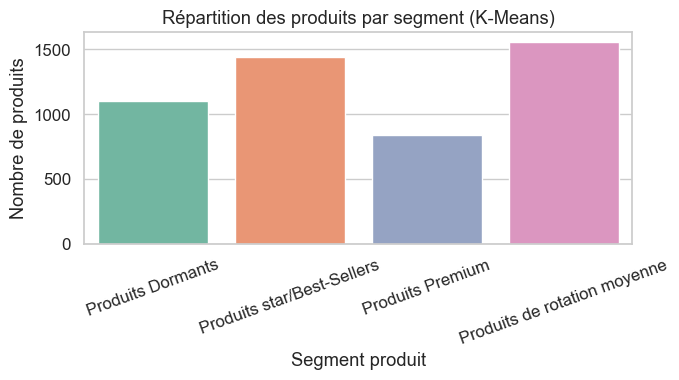

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.countplot(data=product_stats, x="Cluster_Label", order=cluster_labels.values(), palette="Set2")
plt.title("Répartition des produits par segment (K-Means)")
plt.xlabel("Segment produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [107]:
# Sauvegarde du DataFrame avec les clusters
product_stats.to_csv("product_stats_clustered.csv", index=False, encoding="utf-8-sig")

print("✅ Fichier 'product_stats_clustered.csv' enregistré avec succès.")


✅ Fichier 'product_stats_clustered.csv' enregistré avec succès.
